## 알츠하이머 엑스레이 사진 분류 프로젝트

### 사용 데이터셋
- 데이터셋 링크
    - 캐글: https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset/data
    - 허깅페이스: https://huggingface.co/datasets/Falah/Alzheimer_MRI
- 흑백 사진
- 라벨
    - '0': Mild_Demented
    - '1': Moderate_Demented
    - '2': Non_Demented
    - '3': Very_Mild_Demented
- 이미지 데이터셋: 6,400개

## 사용 모델
- pretrained InceptionV3

In [3]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### Load the dataset

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datasets import load_dataset

In [5]:
# Load the Falah/Alzheimer_MRI dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# Print the number of examples and the first few samples
print("Number of train examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Sample data:")
for example in train_dataset[:5]:
    print(example)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Number of train examples: 5120
Number of test examples: 1280
Sample data:
image
label


In [6]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5120
})

### Check image size and label distribution
- 라벨 분포를 보면 클래스 1의 샘플 수가 매우 적어 클래스 불균형이 존재
- 이를 해결하기 위해 데이터 증강(Data Augmentation)이나 가중치 조정(class weights)을 적용하는 방법도 있지만 현재도 학습 잘 되는 편


First image size (PIL Image): (128, 128)
Unique labels: {0, 1, 2, 3}
Label distribution: {0: 724, 1: 49, 2: 2566, 3: 1781}


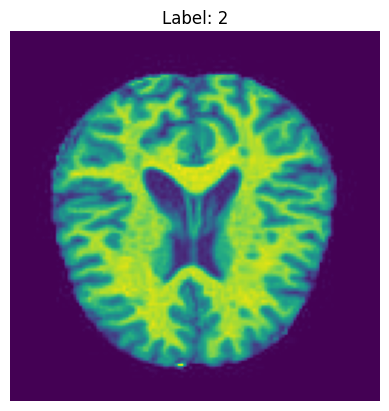

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Checking the first image size and label
first_image = train_dataset[0]['image']
first_label = train_dataset[0]['label']

# Print the shape of the first image (if it is a PIL image or numpy array)
if isinstance(first_image, np.ndarray):
    print(f"First image shape (numpy array): {first_image.shape}")
elif hasattr(first_image, 'size'):  # If it's a PIL Image
    print(f"First image size (PIL Image): {first_image.size}")

# Check the unique labels in the dataset
labels = [item['label'] for item in train_dataset]
unique_labels = set(labels)

# Displaying label distribution
label_counts = {label: labels.count(label) for label in unique_labels}
print(f"Unique labels: {unique_labels}")
print(f"Label distribution: {label_counts}")

# Optional: Show the first image
plt.imshow(first_image)
plt.title(f"Label: {first_label}")
plt.axis('off')  # Hide axes
plt.show()

- RGB가 아닌 그레이 스케일 1채널 이미지

In [8]:
# Check the number of channels for the first image
import numpy as np

first_image = train_dataset[0]['image']  # Load the first image

if isinstance(first_image, np.ndarray):  # If the image is a numpy array
    print(f"Image shape: {first_image.shape}")  # Shape will include channels
    if first_image.shape[-1] == 1:
        print("The image is Grayscale (1 channel).")
    elif first_image.shape[-1] == 3:
        print("The image is RGB (3 channels).")
else:  # If the image is a PIL Image
    print(f"Image mode: {first_image.mode}")  # PIL Image mode can tell us about channels
    if first_image.mode == 'L':
        print("The image is Grayscale (1 channel).")
    elif first_image.mode == 'RGB':
        print("The image is RGB (3 channels).")

Image mode: L
The image is Grayscale (1 channel).


### Create DataLoader
- 팀원들과 맞춘 이미지 transforms
  - RGB 채널로 변환
  - ToTensor
  - 모델에 따라 Resize (안 해도 되면 기존 이미지 사이즈 128 x 128 그대로)

In [9]:
class AlzheimerDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = data['image']  # Assuming 'image' field exists
        label = data['label']  # Assuming 'label' field exists
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
'''
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception model expects 299x299 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
'''

# 이미지 사이즈, 채널 등 변경
# 그레이 스케일 이미지 -> RGB 3 채널로 변경하는 코드 추가
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.Resize((299, 299)),  # Resize to InceptionV3 input size
    transforms.ToTensor()
])


- 팀원들과 맞춘 하이퍼 파라미터
  - batch size: 64
  - CrossEntropyLoss
  - Adam
  - learning rate: 3e-4
  - weight decay: 1e-3
  - epoch: 15

In [11]:
train_data = AlzheimerDataset(train_dataset, transform=transform)
test_data = AlzheimerDataset(test_dataset, transform=transform)

In [12]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Training & Evaluation

- pretrained InceptionV3 모델은 기본적으로 **RGB 이미지(3채널)**를 처리하도록 설계됨.
- 이는 모델이 ImageNet 데이터셋으로 학습되었기 때문
- ImageNet은 모든 이미지가 RGB(3채널) 형식이므로, 모델의 입력 레이어는 3채널 이미지만 지원

In [13]:
model = models.inception_v3(pretrained=True)  # Load the pretrained InceptionV3 model
model.aux_logits = False  # Disable auxiliary logits (for multi-output heads)
model.fc = nn.Linear(model.fc.in_features, len(set(train_dataset['label'])))  # Modify final laye

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 85.0MB/s] 


In [17]:
# Instantiate InceptionV3 model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.inception_v3(pretrained=True)
model.aux_logits = False
model.fc = nn.Linear(model.fc.in_features, len(set(train_dataset['label'])))  # Modify final layer
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

epochs = 15
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_f1_scores, test_f1_scores = [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Collect predictions and labels for metrics
        _, preds = torch.max(outputs, 1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    # Training metrics
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_accuracies.append(train_accuracy)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    train_f1_scores.append(train_f1)

    # Evaluation
    model.eval()
    running_loss = 0.0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    # Testing metrics
    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    test_accuracies.append(test_accuracy)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
    test_f1_scores.append(test_f1)

    # Print metrics for this epoch
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f} - "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - Train Loss: 0.6547, Train Acc: 0.7168, Train F1: 0.7136 - Test Loss: 0.4160, Test Acc: 0.8414, Test F1: 0.8340
Epoch 2/15 - Train Loss: 0.1906, Train Acc: 0.9320, Train F1: 0.9319 - Test Loss: 0.4252, Test Acc: 0.8406, Test F1: 0.8426
Epoch 3/15 - Train Loss: 0.0760, Train Acc: 0.9715, Train F1: 0.9715 - Test Loss: 0.3743, Test Acc: 0.8516, Test F1: 0.8620
Epoch 4/15 - Train Loss: 0.0551, Train Acc: 0.9824, Train F1: 0.9824 - Test Loss: 0.4514, Test Acc: 0.8680, Test F1: 0.8622
Epoch 5/15 - Train Loss: 0.0440, Train Acc: 0.9836, Train F1: 0.9836 - Test Loss: 0.1853, Test Acc: 0.9297, Test F1: 0.9310
Epoch 6/15 - Train Loss: 0.0513, Train Acc: 0.9828, Train F1: 0.9828 - Test Loss: 0.2953, Test Acc: 0.8930, Test F1: 0.8924
Epoch 7/15 - Train Loss: 0.0386, Train Acc: 0.9852, Train F1: 0.9851 - Test Loss: 0.3604, Test Acc: 0.8766, Test F1: 0.8759
Epoch 8/15 - Train Loss: 0.0430, Train Acc: 0.9844, Train F1: 0.9844 - Test Loss: 0.2179, Test Acc: 0.9273, Test F1: 0.9282
Epoch 9/

### Visualizations

- Plot Accuracy & Loss

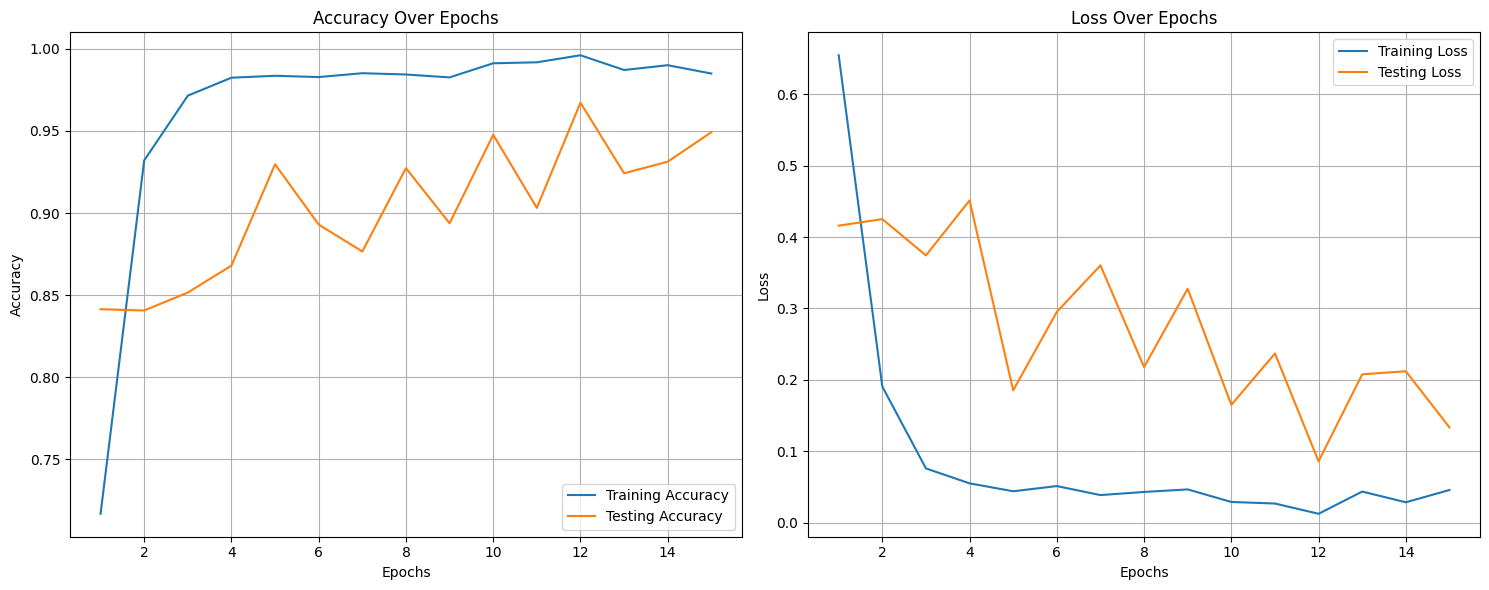

In [18]:
import matplotlib.pyplot as plt

# 1행 2열 figure
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot Accuracy
axs[0].plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
axs[0].plot(range(1, epochs + 1), test_accuracies, label="Testing Accuracy")
axs[0].set_title("Accuracy Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(range(1, epochs + 1), train_losses, label="Training Loss")
axs[1].plot(range(1, epochs + 1), test_losses, label="Testing Loss")
axs[1].set_title("Loss Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# 시각화
plt.tight_layout()
plt.show()


- Plot F1 score & Confusion Matrix

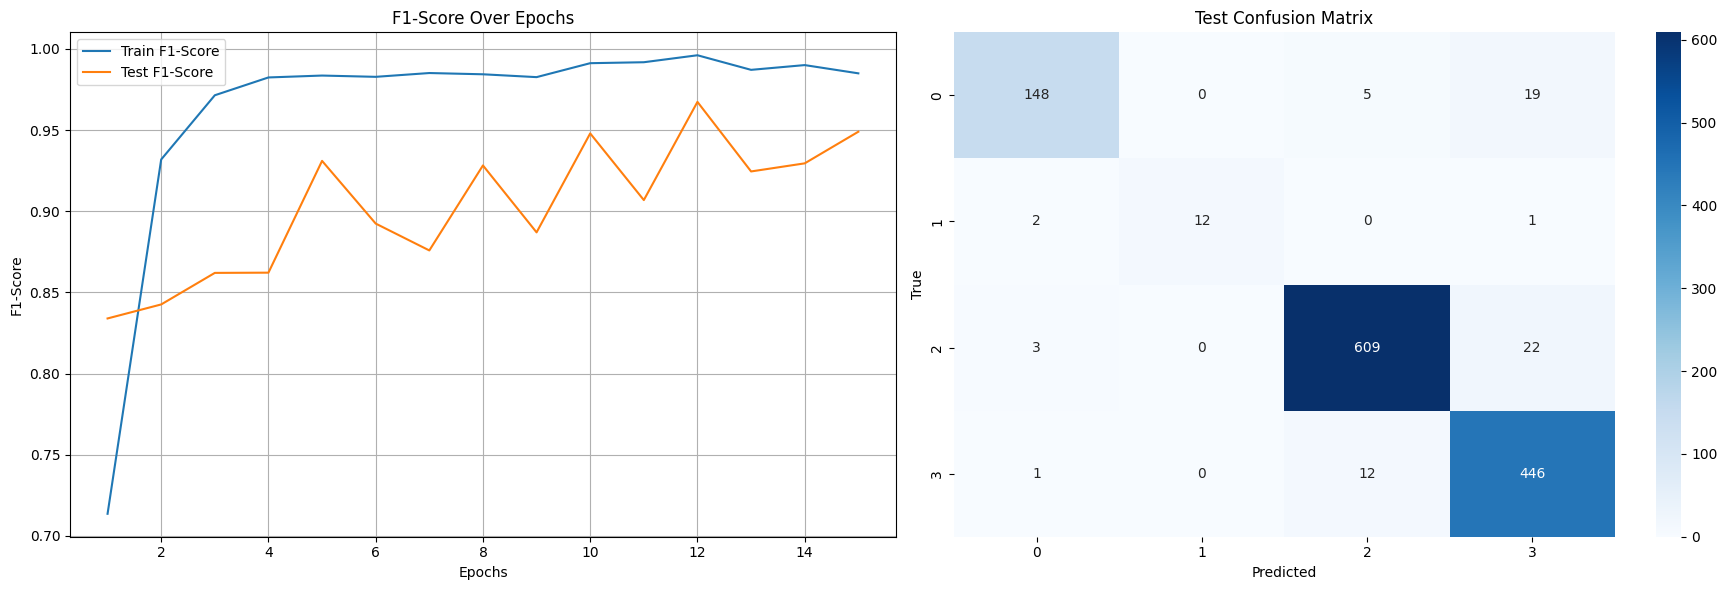

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1행 2열 figure
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot F1-Score
axs[0].plot(range(1, epochs + 1), train_f1_scores, label="Train F1-Score")
axs[0].plot(range(1, epochs + 1), test_f1_scores, label="Test F1-Score")
axs[0].set_title("F1-Score Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("F1-Score")
axs[0].legend()
axs[0].grid(True)

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Test Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

# 시각화
plt.tight_layout()
plt.show()


- Label Distribution (Actual vs Predicted)

In [22]:
from collections import Counter

def plot_label_distribution(labels, preds, title):
    actual_counts = Counter(labels)
    predicted_counts = Counter(preds)
    all_classes = sorted(set(labels))
    actual_distribution = [actual_counts[cls] for cls in all_classes]
    predicted_distribution = [predicted_counts[cls] for cls in all_classes]

    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    indices = np.arange(len(all_classes))
    plt.bar(indices, actual_distribution, width=bar_width, label="Actual Labels", alpha=0.7)
    plt.bar(indices + bar_width, predicted_distribution, width=bar_width, label="Predicted Labels", alpha=0.7)
    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(indices + bar_width / 2, all_classes)
    plt.legend()
    plt.grid(True)
    plt.show()

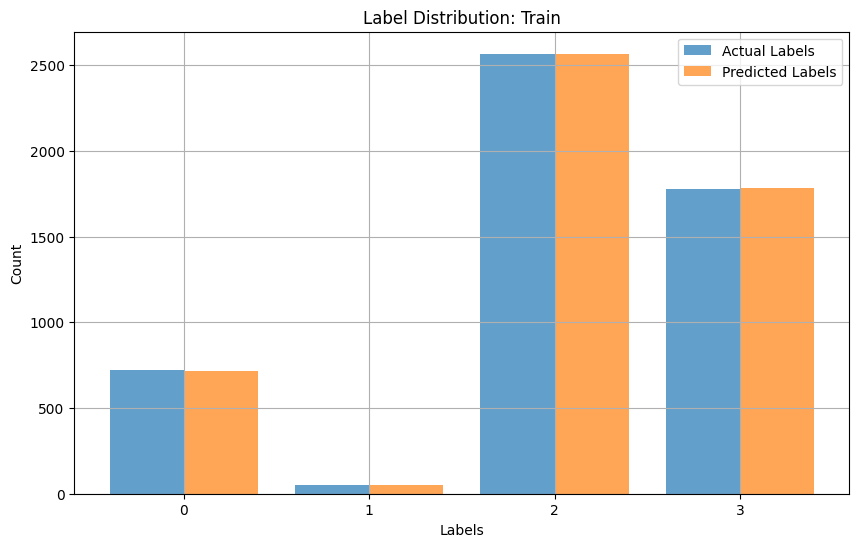

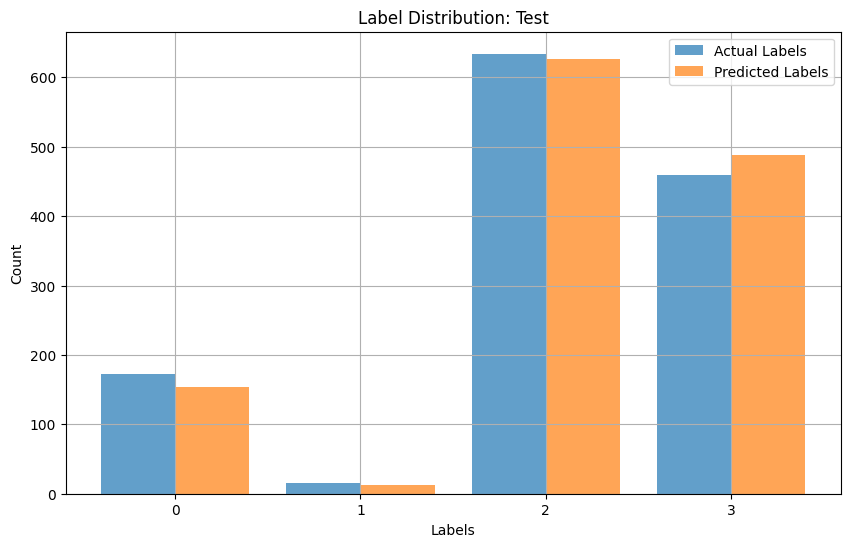

In [23]:
# Train Label Distribution
plot_label_distribution(all_train_labels, all_train_preds, "Label Distribution: Train")

# Test Label Distribution
plot_label_distribution(all_test_labels, all_test_preds, "Label Distribution: Test")